### 0. Imports et chemins 

In [102]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

RANDOM_STATE = 42

# 🛠️ À adapter
DATA_DIR = r"C:\Users\olivi\Downloads\SCHOOL\EL KAROUI\Personal projects\AI For Alpha ML challenge"
TRAIN_PATH = DATA_DIR + r"\train.csv"
TEST_PATH  = DATA_DIR + r"\test.csv"
SUB_PATH   = DATA_DIR + r"\sample_submission.csv"


### 1. Chargement des données 

In [ ]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

print('train shape:', train.shape)
print('test  shape:', test.shape)
print('sub   shape:', sub.shape)

TARGET_COL = "TARGET"
feature_cols = [c for c in train.columns if c.startswith("var")]

X_raw = train[feature_cols].copy()
y     = train[TARGET_COL].astype(int).values
X_test_raw = test[feature_cols].copy()



train shape: (104998, 12)
test  shape: (45002, 11)
sub   shape: (45002, 2)
Features gardées : ['var1', 'var2', 'var3', 'var4', 'var7', 'var9', 'var10']


In [117]:
import pandas as pd

# On part de ton DataFrame train avec 'TARGET' et des colonnes var...
target_col = "TARGET"
exclude_cols = ["ID", target_col]

# On filtre les colonnes candidates
num_cols = [c for c in train.columns if c not in exclude_cols]

# Fonction pour calculer les 3 corrélations avec la cible
def corr_with_target(df, target, cols):
    rows = []
    for c in cols:
        try:
            pear = df[[c, target]].corr(method="pearson").iloc[0,1]
            spear = df[[c, target]].corr(method="spearman").iloc[0,1]
            kend = df[[c, target]].corr(method="kendall").iloc[0,1]
            rows.append({"feature": c, "pearson": pear, "spearman": spear, "kendall": kend})
        except Exception:
            rows.append({"feature": c, "pearson": None, "spearman": None, "kendall": None})
    return pd.DataFrame(rows).set_index("feature").sort_values("pearson", ascending=False)

corr_df = corr_with_target(train, target_col, num_cols)

# Aperçu
print(corr_df.head(10))


          pearson  spearman   kendall
feature                              
var3     0.121607  0.254440  0.249376
var7     0.112982  0.337574  0.334952
var9     0.098508  0.272735  0.271341
var10    0.041778  0.041476  0.038921
var1    -0.003241  0.239012  0.196069
var4    -0.005621  0.021534  0.017589
var8    -0.008175 -0.036624 -0.034023
var5    -0.020071 -0.066893 -0.054714
var6    -0.029222 -0.038212 -0.032145
var2    -0.114204 -0.115626 -0.095280


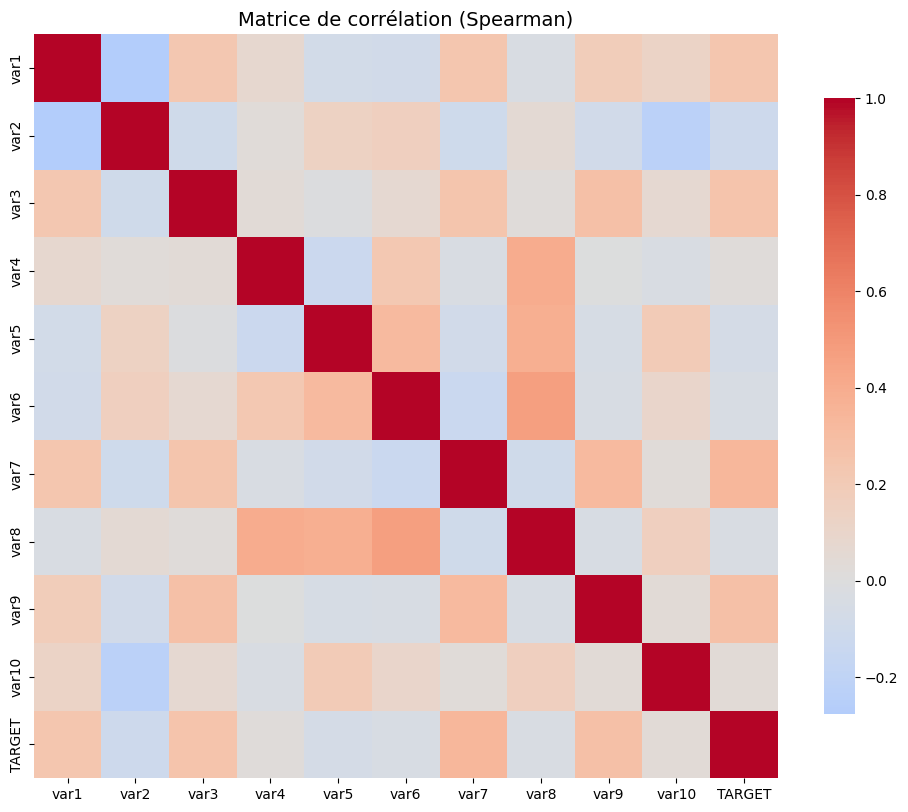

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,TARGET
var1,1.000000,-0.276756,0.232703,0.076916,-0.080895,-0.089066,0.237157,-0.029627,0.185968,0.117385,0.239012
var2,-0.276756,1.000000,-0.093762,0.030318,0.134589,0.157605,-0.102758,0.053476,-0.085713,-0.227706,-0.115626
var3,0.232703,-0.093762,1.000000,0.037365,-0.011517,0.064884,0.250994,0.022096,0.277198,0.070981,0.254440
var4,0.076916,0.030318,0.037365,1.000000,-0.131712,0.225492,-0.032567,0.401323,0.001466,-0.036492,0.021534
var5,-0.080895,0.134589,-0.011517,-0.131712,1.000000,0.312789,-0.085491,0.389633,-0.052272,0.200659,-0.066893


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Colonnes à garder (on enlève juste ID si présent)
cols = [c for c in train.columns if c != "ID"]

# Matrice de corrélation Spearman
corr_spear = train[cols].corr(method="spearman")

# Affichage heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_spear, cmap="coolwarm", center=0,
            square=True, cbar_kws={"shrink": 0.8})
plt.title("Matrice de corrélation (Spearman)", fontsize=14)
plt.show()

# Si tu veux aussi récupérer la matrice en DataFrame
corr_spear.head(10)


In [138]:
# —— À placer juste après le chargement des données ——
DROP_VARS = {"var5", "var6", "var8"}

# 1) Colonnes de features filtrées
feature_cols = [c for c in train.columns if c.startswith("var") and c not in DROP_VARS]

# 2) Matrices X / y / X_test alignées sur ces colonnes
X       = train[feature_cols].copy()
y       = train["TARGET"].astype(int).values
X_test  = test[feature_cols].copy()

# (facultatif) Vérifs
assert set(X.columns) == set(X_test.columns), "Train/Test pas alignés après drop."
print("Features gardées :", feature_cols)



Features gardées : ['var1', 'var2', 'var3', 'var4', 'var7', 'var9', 'var10']


### 2. Analyse des valeurs manquantes 

In [139]:
from statsmodels.stats.proportion import proportions_ztest

def bh_fdr(pvals: pd.Series) -> pd.Series:
    p = pvals.values
    n = len(p)
    order = np.argsort(p)
    ranked = np.empty(n, dtype=float)
    cummin = 1.0
    for i, idx in enumerate(order[::-1], start=1):
        rank = n - i + 1
        adj = p[idx] * n / rank
        cummin = min(cummin, adj)
        ranked[idx] = cummin
    return pd.Series(ranked, index=pvals.index)

def test_missingness_assoc(df: pd.DataFrame, features: list, target: str) -> pd.DataFrame:
    rows = []
    for col in features:
        if not df[col].isna().any():
            continue
        m = df[col].isna()
        n_na, n_non = int(m.sum()), int((~m).sum())
        if n_na == 0 or n_non == 0:
            continue
        pos_non = int(df.loc[~m, target].sum())
        pos_na  = int(df.loc[m,  target].sum())
        rate_non = pos_non / n_non
        rate_na  = pos_na  / n_na
        diff = rate_na - rate_non
        z, p = proportions_ztest([pos_non, pos_na], [n_non, n_na])
        rows.append({
            "feature": col,
            "n_non_na": n_non, "n_na": n_na,
            "rate_non_na": rate_non, "rate_na": rate_na,
            "diff_na_minus_non": diff, "z": z, "p_value": p
        })
    out = pd.DataFrame(rows)
    if out.empty:
        return out
    out["p_adj_bh"] = bh_fdr(out["p_value"])
    out["signif"] = pd.cut(
        out["p_adj_bh"], bins=[-np.inf, 0.001, 0.01, 0.05, np.inf],
        labels=["***", "**", "*", ""]
    )
    return out.sort_values(["p_adj_bh", "p_value"]).reset_index(drop=True)

res_missing = test_missingness_assoc(train, feature_cols, TARGET_COL)
res_missing


,feature,n_non_na,n_na,rate_non_na,rate_na,diff_na_minus_non,z,p_value,p_adj_bh,signif
0,var10,102238,2760,0.067304,0.04529,-0.022014,4.573173,0.000005,0.000005,***


### 3. Préparation des features

In [140]:
def prepare_features(train_df, test_df, feature_cols, res_missing, alpha=0.05, impute=False, impute_strategy="median"):
    X_tr = train_df[feature_cols].copy()
    X_te = test_df[feature_cols].copy()

    if "p_adj_bh" in res_missing.columns:
        sig_cols = res_missing.loc[res_missing["p_adj_bh"] <= alpha, "feature"].tolist()
    else:
        sig_cols = res_missing.loc[res_missing["p_value"] <= alpha, "feature"].tolist()
    sig_cols = [c for c in sig_cols if c in feature_cols]
    print("Colonnes avec NA informatifs:", sig_cols)

    for c in sig_cols:
        X_tr[c + "_isna"] = X_tr[c].isna().astype(int)
        X_te[c + "_isna"] = X_te[c].isna().astype(int)

    final_cols = list(X_tr.columns)
    fitted_imputer = None
    if impute:
        fitted_imputer = SimpleImputer(strategy=impute_strategy)
        X_tr = pd.DataFrame(fitted_imputer.fit_transform(X_tr), columns=final_cols, index=train_df.index)
        X_te = pd.DataFrame(fitted_imputer.transform(X_te),     columns=final_cols, index=test_df.index)

    return X_tr, X_te, final_cols, fitted_imputer

# Recommandé pour HGB : pas d’imputation (il gère NaN), mais on ajoute les masks si significatifs
X_prep, X_test_prep, feat_cols_final, _ = prepare_features(
    train_df=train, test_df=test,
    feature_cols=feature_cols, res_missing=res_missing,
    alpha=0.05, impute=False
)


Colonnes avec NA informatifs: ['var10']


### 4. Poids de classe (déséquilibre)

In [141]:
pos_w = (y == 0).sum() / max((y == 1).sum(), 1)
sample_w = np.where(y == 1, pos_w, 1.0)
pos_w, sample_w[:5]


(13.986868398515558,
 array([13.9868684,  1.       ,  1.       ,  1.       ,  1.       ]))

### 5. Utilitaire CV 

In [169]:
def cv_predict_proba(model, X, y, n_splits=5, random_state=42, fit_kwargs=None, verbose=0):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve
    from sklearn.base import clone
    import numpy as np

    def best_threshold_for_f1(y_true, y_prob):
        import numpy as np

        # Trie des probabilités par ordre décroissant
        thresholds = np.linspace(0, 1, 501)  # grille de seuils
        best_f1, best_thr = 0.0, 0.5

        for t in thresholds:
            y_pred = (y_prob >= t).astype(int)
            tp = np.sum((y_pred == 1) & (y_true == 1))
            fp = np.sum((y_pred == 1) & (y_true == 0))
            fn = np.sum((y_pred == 0) & (y_true == 1))

            denom = 2 * tp + fp + fn
            f1 = (2 * tp / denom) if denom > 0 else 0.0

            if f1 > best_f1:
                best_f1 = f1
                best_thr = t

        return float(best_thr), float(best_f1)



    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof = np.zeros(len(y), dtype=float)

    def _subset_sample_weights_in_kwargs(kw, tr_idx):
        if kw is None: 
            return {}
        kw = kw.copy()
        for k in list(kw.keys()):
            if "sample_weight" in k:
                v = kw[k]
                try:
                    if hasattr(v, "__len__") and len(v) == len(y):
                        kw[k] = v[tr_idx]
                except Exception:
                    pass
        return kw

    per_fold = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        mdl = clone(model)
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        base_kw = fit_kwargs or {}
        kw = _subset_sample_weights_in_kwargs(base_kw, tr_idx)

        mdl.fit(X_tr, y_tr, **kw)
        prob = mdl.predict_proba(X_va)[:, 1]
        oof[va_idx] = prob

        thr, f1b = best_threshold_for_f1(y_va, prob)
        if verbose:
            print(f"Fold {fold} | F1@best={f1b:.4f} | thr={thr:.4f}")
        per_fold.append((thr, f1b))

    thr_oof, f1_oof = best_threshold_for_f1(y, oof)
    ap = average_precision_score(y, oof)
    if verbose:
        print(f"\nOOF F1@best={f1_oof:.4f} | thr_global={thr_oof:.4f} | PR-AUC={ap:.4f}")
    return oof, per_fold, thr_oof, f1_oof, ap


### 6. Baseline HGB (centrée F1)

In [170]:
base_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

oof_prob, per_fold, thr_oof, f1_oof, ap_oof = cv_predict_proba(
    base_model, X_prep, y,
    n_splits=6, random_state=RANDOM_STATE,
    fit_kwargs={"sample_weight": sample_w},
    verbose=1
)

y_oof = (oof_prob >= thr_oof).astype(int)
print(f"\nBaseline -> F1@best(OOF)={f1_oof:.4f} | seuil OOF={thr_oof:.3f} | PR-AUC={ap_oof:.4f}")
print("Matrice de confusion OOF au seuil global :\n", confusion_matrix(y, y_oof))
print("\nReport (OOF) :\n", classification_report(y, y_oof, digits=4))


Fold 1 | F1@best=0.4377 | thr=0.7400
Fold 2 | F1@best=0.4432 | thr=0.7760
Fold 3 | F1@best=0.4458 | thr=0.8060
Fold 4 | F1@best=0.4333 | thr=0.7760
Fold 5 | F1@best=0.4282 | thr=0.8140
Fold 6 | F1@best=0.4517 | thr=0.8200

OOF F1@best=0.4349 | thr_global=0.7520 | PR-AUC=0.3842

Baseline -> F1@best(OOF)=0.4349 | seuil OOF=0.752 | PR-AUC=0.3842
Matrice de confusion OOF au seuil global :
 [[91944  6048]
 [ 3379  3627]]

Report (OOF) :
               precision    recall  f1-score   support

           0     0.9646    0.9383    0.9512     97992
           1     0.3749    0.5177    0.4349      7006

    accuracy                         0.9102    104998
   macro avg     0.6697    0.7280    0.6931    104998
weighted avg     0.9252    0.9102    0.9168    104998



## 7. Tuning léger orienté F1@best et prédiction

In [171]:
# ==== HGB - OPTIMISATION (F1@best), NSPLITS=7 / N_TRIALS=10 + SUBMISSION ====
# !pip -q install optuna

import optuna
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import clone

RANDOM_STATE = 42
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Données & poids inchangés ---

prep_tree = Pipeline([("imp", SimpleImputer(strategy="median", add_indicator=True))])

def build_hgb(params: dict) -> Pipeline:
    return Pipeline([
        ("prep", prep_tree),
        ("clf", HistGradientBoostingClassifier(
            learning_rate     = params["learning_rate"],
            max_iter          = params["max_iter"],
            max_leaf_nodes    = params["max_leaf_nodes"],
            min_samples_leaf  = params["min_samples_leaf"],
            max_bins          = params["max_bins"],
            l2_regularization = params["l2_regularization"],
            early_stopping=True, validation_fraction=0.1,
            n_iter_no_change=20, tol=1e-7,
            random_state      = RANDOM_STATE
        ))
    ])

def objective(trial: optuna.trial.Trial) -> float:
    params = {
        "learning_rate":     trial.suggest_float("learning_rate", 0.01, 0.20, log=True),
        "max_iter":          trial.suggest_int("max_iter", 200, 600),
        "max_leaf_nodes":    trial.suggest_int("max_leaf_nodes", 31, 127),
        "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 10, 80),
        "max_bins":          trial.suggest_int("max_bins", 64, 128),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-9, 1e-1, log=True),
    }
    model = build_hgb(params)
    _, _, _, f1, _ = cv_predict_proba(
        model, X, y,
        n_splits=6, random_state=RANDOM_STATE,
        fit_kwargs={"clf__sample_weight": sample_w},
        verbose=1
    )
    return f1

sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)
study   = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

study.optimize(objective, n_trials=10, show_progress_bar=True)  # ou timeout=900

print("Best F1_OOF:", study.best_value)
print("Best params:", study.best_params)

best_hgb = build_hgb(study.best_params)
oof, _, thr_oof, f1_oof, ap_oof = cv_predict_proba(
    best_hgb, X, y,
    n_splits=6, random_state=RANDOM_STATE,
    fit_kwargs={"clf__sample_weight": sample_w},
    verbose=1
)
print(f"[BEST HGB] F1_OOF@best={f1_oof:.4f} | thr_OOF={thr_oof:.3f} | PR-AUC={ap_oof:.4f}")

final_hgb = clone(best_hgb).fit(X, y, clf__sample_weight=sample_w)
test_prob = final_hgb.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= thr_oof).astype(int)
submission = pd.DataFrame({"ID": test["ID"], "TARGET": test_pred})


display(submission.head())
print("Seuil appliqué (OOF, HGB optimisé F1, 10 essais, 6 folds):", round(float(thr_oof), 3))


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1 | F1@best=0.4352 | thr=0.7500
Fold 2 | F1@best=0.4528 | thr=0.7920
Fold 3 | F1@best=0.4458 | thr=0.7920
Fold 4 | F1@best=0.4340 | thr=0.7560
Fold 5 | F1@best=0.4342 | thr=0.7840
Fold 6 | F1@best=0.4535 | thr=0.7960

OOF F1@best=0.4399 | thr_global=0.7960 | PR-AUC=0.3853
Fold 1 | F1@best=0.4365 | thr=0.7500
Fold 2 | F1@best=0.4530 | thr=0.8080
Fold 3 | F1@best=0.4445 | thr=0.8080
Fold 4 | F1@best=0.4332 | thr=0.7520
Fold 5 | F1@best=0.4313 | thr=0.7740
Fold 6 | F1@best=0.4506 | thr=0.8020

OOF F1@best=0.4379 | thr_global=0.7620 | PR-AUC=0.3827
Fold 1 | F1@best=0.4370 | thr=0.7520
Fold 2 | F1@best=0.4468 | thr=0.7680
Fold 3 | F1@best=0.4358 | thr=0.7660
Fold 4 | F1@best=0.4358 | thr=0.7740
Fold 5 | F1@best=0.4292 | thr=0.7780
Fold 6 | F1@best=0.4510 | thr=0.7960

OOF F1@best=0.4381 | thr_global=0.7720 | PR-AUC=0.3895
Fold 1 | F1@best=0.4351 | thr=0.7340
Fold 2 | F1@best=0.4476 | thr=0.7700
Fold 3 | F1@best=0.4404 | thr=0.8080
Fold 4 | F1@best=0.4332 | thr=0.7740
Fold 5 | F1@best=0

,ID,TARGET
0,104999,0
1,105000,0
2,105001,0
3,105002,1
4,105003,0


Seuil appliqué (OOF, HGB optimisé F1, 10 essais, 6 folds): 0.796


In [172]:
submission.to_csv("submission.csv", index=False)
